In [5]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import sparql_dataframe



In [2]:
endpoint = "https://api.druid.datalegend.net/datasets/LvanWissen/Occasional-Poetry/services/Occasional-Poetry/sparql"

## Welke predicaten zitten er in de GGD database?

In [4]:
q = """
SELECT ?p (COUNT(?p) AS ?count)
WHERE {
    ?s ?p ?o.
  }
ORDER BY DESC(?count)
"""

df = sparql_dataframe.get(endpoint, q)

print(df)



                                                    p   count
0     http://www.w3.org/1999/02/22-rdf-syntax-ns#type  140050
1          http://www.w3.org/2000/01/rdf-schema#label  109107
2                              http://schema.org/name   79751
3                        https://w3id.org/pnv#hasName   42978
4                            http://schema.org/author   29820
5                             http://schema.org/about   29424
6                http://www.w3.org/2002/07/owl#sameAs   25128
7                    https://w3id.org/pnv#literalName   16803
8                    https://w3id.org/pnv#baseSurname   16735
9                      https://w3id.org/pnv#givenName   14140
10                           http://schema.org/gender   12903
11                         http://schema.org/roleName   11249
12                      http://schema.org/description   10246
13   http://semanticweb.cs.vu.nl/2009/11/sem/roleType    9576
14   http://www.w3.org/1999/02/22-rdf-syntax-ns#value    9576
15   htt

## Hoeveel auteurs zitten er in de ggd?

In [6]:
q = """
PREFIX schema: <http://schema.org/>   
PREFIX w3: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX w3ID: <https://w3id.org/pnv#>

SELECT (COUNT(?author) AS ?count)
WHERE {
  ?s schema:publication ?publication;
  schema:author ?authorRole.
  ?authorRole schema:author ?author 
  }
ORDER BY DESC(?count)
"""

df = sparql_dataframe.get(endpoint, q)

print(df)

   count
0  14910


Of via een andere weg:

In [7]:
q = """
PREFIX schema: <http://schema.org/>   
PREFIX w3: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX w3ID: <https://w3id.org/pnv#>

SELECT (COUNT(?author) AS ?count)
WHERE {
    ?book a schema:Book ;
    schema:author ?authorRole .

    ?authorRole a schema:Role ;
    schema:author ?author .

    ?author a schema:Person .
    }
ORDER BY DESC(?count)
"""

df = sparql_dataframe.get(endpoint, q)

print(df)




   count
0  14910


Maar daar kunnen best wat dubbeltellingen bij zitten. Laten we die eruithalen.

In [8]:
q = """
PREFIX schema: <http://schema.org/>   
PREFIX w3: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX w3ID: <https://w3id.org/pnv#>

SELECT (COUNT(DISTINCT ?ID) AS ?count)
WHERE {
  ?work schema:publication ?publication;
  schema:author ?author.
  ?author w3ID:hasName ?ID.  
  }
"""

df = sparql_dataframe.get(endpoint, q)


print(df)



   count
0   6942


## Hoeveel van die auteurs hebben een link in de NTA?


Dit is te onderscheiden doordat ze "thes" in hun URI hebben ("thes"  staat voor "thesaurus").\

<span style="color:red">Ik kom hier op 2620 uit en dat is volgens mij een veel lager getal dan ik meen gehoord te hebben. Doe ik iets fout?</span>.

In [10]:
q = """
PREFIX schema: <http://schema.org/>   
PREFIX w3: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX w3ID: <https://w3id.org/pnv#>


SELECT  (COUNT(DISTINCT ?author) AS ?count)
WHERE {
  ?work schema:publication ?publication;
  schema:author ?authorRole.
  ?authorRole schema:author ?author.
  FILTER(CONTAINS(STR(?author), 'thes'))
  }

"""

df = sparql_dataframe.get(endpoint, q)

print(df)



   count
0   2620


Of via een andere route:

In [11]:
q = """
PREFIX schema: <http://schema.org/>   
PREFIX w3: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX w3ID: <https://w3id.org/pnv#>


SELECT  (COUNT(DISTINCT ?author) AS ?count)
WHERE {
    ?book a schema:Book ;
    schema:author ?authorRole .
    ?authorRole a schema:Role ;
    schema:author ?author .
    ?author a schema:Person .
    FILTER(CONTAINS(STR(?author), 'thes'))
  }

"""

df = sparql_dataframe.get(endpoint, q)

print(df)




   count
0   2620


## Hoeveel van die auteurs hebben een UvA URI?

In [12]:
q = """
PREFIX schema: <http://schema.org/>   
PREFIX w3: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX w3ID: <https://w3id.org/pnv#>


SELECT  (COUNT(DISTINCT ?author) AS ?count)
WHERE {
  ?work schema:publication ?publication;
  schema:author ?authorRole.
  ?authorRole schema:author ?author.
  FILTER(CONTAINS(STR(?author), 'uva'))
  }

"""

df = sparql_dataframe.get(endpoint, q)

print(df)


   count
0   4257


## En hoeveel via viaf?

In [13]:
q = """
PREFIX schema: <http://schema.org/>   
PREFIX w3: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX w3ID: <https://w3id.org/pnv#>


SELECT  (COUNT(DISTINCT ?author) AS ?count)
WHERE {
  ?work schema:publication ?publication;
  schema:author ?authorRole.
  ?authorRole schema:author ?author.
  FILTER(CONTAINS(STR(?author), 'viaf'))
  }

"""

df = sparql_dataframe.get(endpoint, q)

print(df)



   count
0     65


## Hoe vaak is een auteur mannelijk of vrouwelijk?

Laten we eerst kijken naar alle boeken die in de GGD zitten. Als een boek er dan twee keer in zit, worden de auteurs twee keer meegeteld.

In [15]:
q = """
PREFIX schema: <http://schema.org/>   
PREFIX w3: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX w3ID: <https://w3id.org/pnv#>

SELECT ?gender (COUNT(?gender) as ?count)
WHERE {
  ?book a schema:Book;
  schema:author ?authorRole.

  ?authorRole schema:author ?author.
  
  ?author schema:gender ?gender.

  }
ORDER BY DESC(?count)
"""

df_gender = sparql_dataframe.get(endpoint, q)

print(df_gender)



                     gender  count
0    http://schema.org/Male  11071
1  http://schema.org/Female    795


Hoe ziet het eruit als je naar unieke werken kijkt?

<span style="color:red">Hoe kan het dat ik hier op een hoger aantal uitkom?</span>.

In [16]:
q = """
PREFIX schema: <http://schema.org/>   
PREFIX w3: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX w3ID: <https://w3id.org/pnv#>

SELECT ?gender (COUNT(?gender) as ?count)
WHERE {
  ?copy schema:exampleOfWork ?work.
  
  ?work schema:author ?authorRole.

  ?authorRole schema:author ?author.

  ?author schema:gender ?gender.

  }
ORDER BY DESC(?count)
"""

df_gender = sparql_dataframe.get(endpoint, q)

print(df_gender)



                     gender  count
0    http://schema.org/Male  15334
1  http://schema.org/Female   1017


Nu kijken naar unieke auteurs.

In [17]:
q = """
PREFIX schema: <http://schema.org/>   
PREFIX w3: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX w3ID: <https://w3id.org/pnv#>

SELECT DISTINCT ?author ?gender
WHERE {
  ?book a schema:Book;
  schema:author ?authorRole.

  ?authorRole schema:author ?author.
  
  ?author schema:gender ?gender.

  }
ORDER BY DESC(?count)
"""

df_gender = sparql_dataframe.get(endpoint, q)

print(df_gender)


                                              author                  gender
0     http://data.bibliotheken.nl/id/thes/p068191960  http://schema.org/Male
1     http://data.bibliotheken.nl/id/thes/p068192983  http://schema.org/Male
2     http://data.bibliotheken.nl/id/thes/p06824357X  http://schema.org/Male
3     http://data.bibliotheken.nl/id/thes/p068381700  http://schema.org/Male
4     http://data.bibliotheken.nl/id/thes/p068417705  http://schema.org/Male
...                                              ...                     ...
4227  http://data.bibliotheken.nl/id/thes/p205474756  http://schema.org/Male
4228  http://data.bibliotheken.nl/id/thes/p230293514  http://schema.org/Male
4229  http://data.bibliotheken.nl/id/thes/p24260840X  http://schema.org/Male
4230  http://data.bibliotheken.nl/id/thes/p31517580X  http://schema.org/Male
4231  http://data.bibliotheken.nl/id/thes/p364396407  http://schema.org/Male

[4232 rows x 2 columns]


In [18]:
gender_count = df_gender.groupby(['gender']).size()
print(gender_count)

gender
http://schema.org/Female     493
http://schema.org/Male      3739
dtype: int64


In de hele ggd zitten dus 493 unieke vrouwelijke auteurs en 3739 unieke mannelijke auteurs.

## Mannen en vrouwen in de NTA

Dus hoe zit die verdeling in de NTA?

In [41]:
q = """
PREFIX schema: <http://schema.org/>   
PREFIX w3: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX w3ID: <https://w3id.org/pnv#>

SELECT DISTINCT ?author ?gender
WHERE {
  ?book a schema:Book;
  schema:author ?authorRole.

  ?authorRole schema:author ?author.
  
  ?author schema:gender ?gender.

  FILTER(CONTAINS(STR(?author), 'thes'))

  }
ORDER BY DESC(?count)
"""

df_gender = sparql_dataframe.get(endpoint, q)

print(df_gender)

                                              author                  gender
0     http://data.bibliotheken.nl/id/thes/p068191960  http://schema.org/Male
1     http://data.bibliotheken.nl/id/thes/p068192983  http://schema.org/Male
2     http://data.bibliotheken.nl/id/thes/p06824357X  http://schema.org/Male
3     http://data.bibliotheken.nl/id/thes/p068381700  http://schema.org/Male
4     http://data.bibliotheken.nl/id/thes/p068417705  http://schema.org/Male
...                                              ...                     ...
2285  http://data.bibliotheken.nl/id/thes/p205474756  http://schema.org/Male
2286  http://data.bibliotheken.nl/id/thes/p230293514  http://schema.org/Male
2287  http://data.bibliotheken.nl/id/thes/p24260840X  http://schema.org/Male
2288  http://data.bibliotheken.nl/id/thes/p31517580X  http://schema.org/Male
2289  http://data.bibliotheken.nl/id/thes/p364396407  http://schema.org/Male

[2290 rows x 2 columns]


In [43]:
gender_count = df_gender.groupby(['gender']).size()
print(gender_count)

gender
http://schema.org/Female     119
http://schema.org/Male      2171
dtype: int64


In de NTA zitten dus 119 vrouwelijke auteurs, en 2171 mannelijke auteurs. Voor de hele ggd geldt: 493 vrouwen en 3739 mannen.

In [51]:
print(round(119/(2171+119)*100), "%")
print(round(493/(493+3739)*100), "%")

5 %
12 %


In [48]:
"""
Under construction
"""

q = """
PREFIX schema: <http://schema.org/>   
PREFIX w3: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX w3ID: <https://w3id.org/pnv#>

SELECT ?p (COUNT(?p) as ?count)
WHERE {
  ?book a schema:Book;
  schema:author ?authorRole.

  ?authorRole schema:author ?author.

  ?author schema:gender schema:Female.
  
  ?author ?p ?o.

  }
ORDER BY DESC(?count)
"""

df_gender = sparql_dataframe.get(endpoint, q)

print(df_gender)

                                                 p  count
0                           http://schema.org/name    824
1       http://www.w3.org/2000/01/rdf-schema#label    824
2                     https://w3id.org/pnv#hasName    795
3  http://www.w3.org/1999/02/22-rdf-syntax-ns#type    795
4                         http://schema.org/gender    795
5                      http://schema.org/birthDate    334
6             http://www.w3.org/2002/07/owl#sameAs    295
7                      http://schema.org/deathDate    282


## Volledigheid van ggd

In [19]:
q = """
PREFIX sc: <http://purl.org/science/owl/sciencecommons/>
PREFIX schema: <http://schema.org/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX sem: <http://semanticweb.cs.vu.nl/2009/11/sem/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?work (COUNT(?work) as ?count)
 WHERE {
  ?book a schema:Book;
  schema:exampleOfWork ?work.
} 
ORDER BY DESC(?count)
"""

df = sparql_dataframe.get(endpoint, q)

print(df)




                                                 work  count
0     http://data.bibliotheken.nl/id/dataset/ggd/4047      9
1     http://data.bibliotheken.nl/id/dataset/ggd/2690      6
2     http://data.bibliotheken.nl/id/dataset/ggd/3104      6
3     http://data.bibliotheken.nl/id/dataset/ggd/5682      6
4     http://data.bibliotheken.nl/id/dataset/ggd/5660      6
...                                               ...    ...
6901   http://data.bibliotheken.nl/id/dataset/ggd/845      1
6902   http://data.bibliotheken.nl/id/dataset/ggd/889      1
6903   http://data.bibliotheken.nl/id/dataset/ggd/892      1
6904   http://data.bibliotheken.nl/id/dataset/ggd/908      1
6905   http://data.bibliotheken.nl/id/dataset/ggd/913      1

[6906 rows x 2 columns]


In [20]:
from copia.utils import basic_stats

abundance = df['count'].to_numpy()
print(basic_stats(abundance))

{'f1': 5620, 'f2': 1003, 'f3': 213, 'f4': 43, 'S': 6906, 'n': 8582}


<AxesSubplot:title={'center':'Distribution of sightings over species'}, xlabel='Species', ylabel='Number of sightings'>

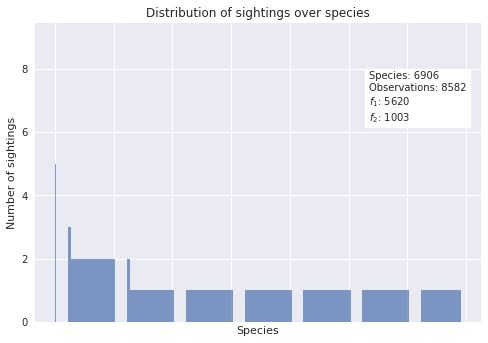

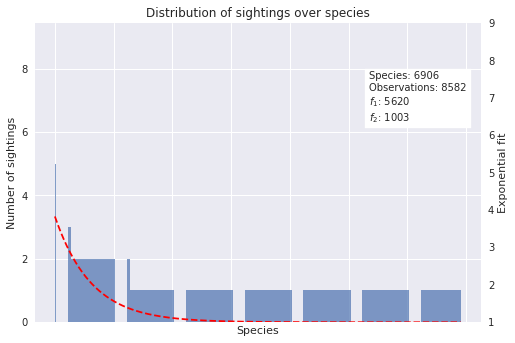

In [22]:
from copia.plot import abundance_counts
abundance_counts(abundance)
abundance_counts(abundance, trendline=True)

In [32]:
from copia.richness import *
lst = []
for m in ('chao1', 'ichao1', 'ace', 'jackknife', 'egghe_proot'):
    estimate = diversity(abundance, method=m, CI = True)
    m_lst = [m, estimate['richness'], estimate['lci'], estimate['uci'] ]
    lst.append(m_lst)

df = pd.DataFrame(lst, columns = ['estimator','richness', 'low', 'high'])
df = df.set_index('estimator')
df = df.astype(int)
print(df)

100%|██████████| 1000/1000 [00:00<00:00, 1242.48it/s]

             richness    low   high
estimator                          
chao1           22649  21631  23666
ichao1          26532  25404  27783
ace             57978  51003  64946
jackknife       26911  25867  27954
egghe_proot     22900  21832  23966
